# Instacart Exploratory Data Analysis: Uncovering Customer Behavior

This notebook performs an in-depth exploratory data analysis (EDA) on the Instacart dataset. The goal is to uncover actionable insights into customer purchasing habits, product popularity, and temporal trends. By understanding these patterns, we can answer key business questions and inform strategic decisions in marketing, inventory management, and customer engagement.

### Key Business Questions:

1.  **What are the general ordering patterns?**
    *   When do customers prefer to place their orders (day of the week, time of day)?
    *   How frequently do customers reorder?
2.  **Which products and categories are most popular?**
    *   Which departments and products are the top sellers?
    *   Which products have the highest reorder rates?
    *   What are the most common items in a customer's first-ever order?
3.  **What are the characteristics of customer purchasing behavior?**
    *   What is the typical number of orders per customer?
    *   How do shopping habits differ between weekdays and weekends?
4.  **Which products are frequently purchased together?**
    *   Can we identify strong product associations to inform cross-selling and bundling strategies?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading and Initial Overview

We begin by loading the cleaned datasets. During the data ingestion phase, we ensured data types were optimized and initial cleaning was performed. Here, we'll load the data and take a first look at its scale and basic statistics.

In [101]:
orders_df = pd.read_csv("../data/clean_orders.csv", dtype={
    'order_id': np.int32,
    'user_id': np.int32,
    'eval_set': 'category',
    'order_number': np.int8,
    'order_dow': 'category',
    'order_hour_of_day': 'category',
    'days_since_prior_order': np.float32
})
order_products_df = pd.read_csv("../data/clean_order_products.csv", dtype={
    'order_id': np.int32,
    'product_id': np.int32,
    'add_to_cart_order': np.int16,
    'reordered': 'category'
})
products_df = pd.read_csv("../data/clean_products.csv", dtype={
    'product_id': np.int32,
    'aisle_id': np.int16,
    'department_id': 'category'
})
departments_df = pd.read_csv("../data/departments.csv", dtype={'department_id': 'category', 'department': 'category'})

In [102]:
# Map numeric day-of-week codes to readable labels (assuming 0=Sunday, 6=Saturday per Instacart docs)
# If your mapping differs, adjust accordingly.
DOW_MAP = {0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'}
try:
    # Convert to int then map (some columns are categorical strings)
    orders_df['order_dow_label'] = orders_df['order_dow'].astype(int).map(DOW_MAP)
except Exception:
    pass  # Fallback silently if mapping not applicable

# Create weekend flag once (0=Sun,6=Sat here; adjust if your calendar differs)
if 'is_weekend' not in orders_df.columns:
    orders_df['is_weekend'] = orders_df['order_dow'].astype(str).isin(['0','6']).astype(int)

## 1. Temporal Ordering Patterns

In [103]:
total_orders = len(orders_df)
total_customers = orders_df['user_id'].nunique()
avg_items_per_order = order_products_df.groupby('order_id').size().mean()
print(f"Total orders: {total_orders}, Total customers: {total_customers}, Avg items/order: {avg_items_per_order:.2f}")

Total orders: 3421083, Total customers: 206209, Avg items/order: 10.09


In [104]:
# KPI summary (will be updated after orders_per_user defined later)
print({'total_orders': total_orders, 'total_customers': total_customers, 'avg_items_per_order': round(avg_items_per_order,2)})

{'total_orders': 3421083, 'total_customers': 206209, 'avg_items_per_order': np.float64(10.09)}


The dataset is substantial, containing over 3.4 million orders from more than 200,000 customers. On average, a customer's basket contains about 10 items. This scale provides a robust foundation for statistical analysis.

### Orders by Day of Week
Understanding when customers shop is crucial for staffing, inventory, and promotions. We first analyze the distribution of orders across the days of the week. (Note: Day 0 and 6 likely represent the weekend).

In [ ]:
orders_by_dow = orders_df['order_dow_label'].value_counts().reindex(['Sun','Mon','Tue','Wed','Thu','Fri','Sat']).fillna(0)
orders_by_dow

order_dow
0    600905
1    587478
2    467260
3    436972
4    426339
5    453368
6    448761
Name: count, dtype: int64

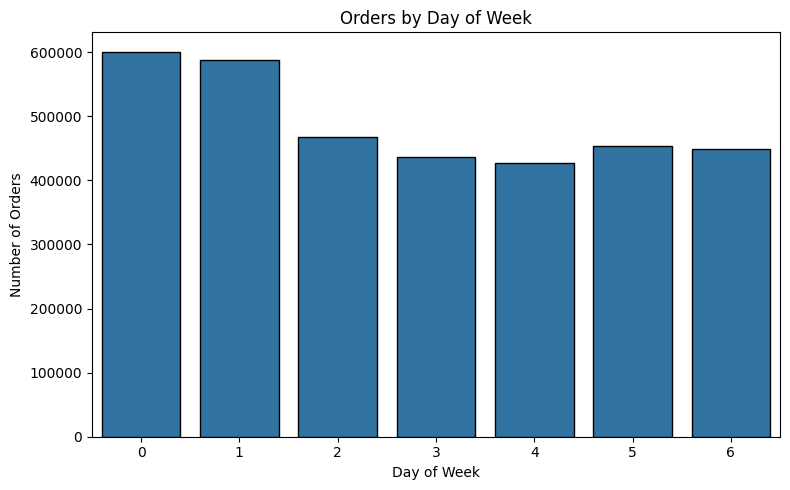

In [139]:
plt.figure(figsize=(8,5))
sns.barplot(x=orders_by_dow.index, y=orders_by_dow.values, edgecolor='black')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.title('Orders by Day of Week')
plt.tight_layout()
plt.show()

**Business Insight:**  
Order volume peaks significantly on days 0 and 6, which presumably represent the weekend. This confirms that most grocery shopping is done on weekends. Instacart can leverage this by running weekend-specific promotions or ensuring higher server capacity and shopper availability during these peak times.

In [107]:
orders_by_hour = orders_df['order_hour_of_day'].value_counts().sort_index().reset_index(name='counts')
orders_by_hour

,order_hour_of_day,counts
0,00,22758
1,01,12398
2,02,7539
3,03,5474
4,04,5527
5,05,9569
6,06,30529
7,07,91868
8,08,178201
9,09,257812


### Orders by Hour of Day
Next, we examine the time of day customers place orders. This helps in understanding daily shopping rhythms.

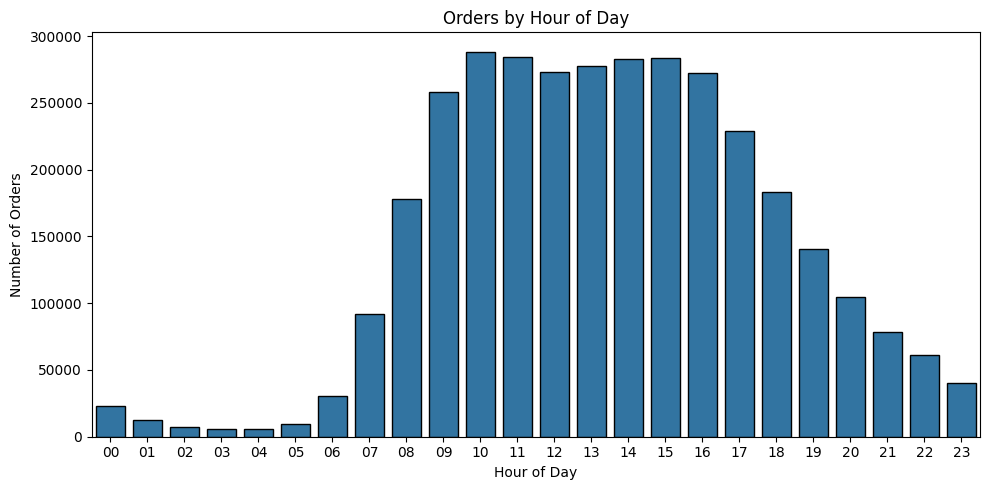

In [108]:
plt.figure(figsize=(10,5))
sns.barplot(data=orders_by_hour,
             x='order_hour_of_day', 
             y='counts',
             edgecolor='black')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.title('Orders by Hour of Day')
plt.tight_layout()
plt.show()

**Business Insight:**  
The busiest hours are from 9 AM to 5 PM, with a peak in the early afternoon. This suggests that customers tend to shop during standard daytime hours. Marketing efforts, such as push notifications, could be timed around these peak hours to maximize engagement.

### Customer Reorder Frequency
This histogram shows how many days typically pass between a customer's orders. It helps us understand the customer purchasing cycle.

Text(0.5, 1.0, 'Distribution of Days Since Prior Order')

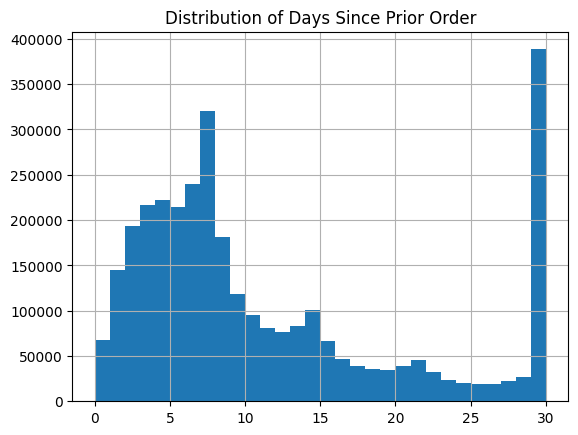

In [109]:
orders_df['days_since_prior_order'].hist(bins=30)
plt.title("Distribution of Days Since Prior Order")

**Business Insight:**  
There are clear spikes at 7, 14, 21, and 30 days, indicating strong weekly and monthly purchasing habits. This is a powerful insight for creating subscription-like services or sending targeted reminders to customers who are likely due for their next order. The large peak at 30 days also suggests many customers use Instacart for monthly stock-ups.

## 2. Product Performance Analysis

### Top 10 Departments by Items Sold
To understand which product categories drive the most sales, we analyze the number of items sold from each department.

In [140]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Get top 7 departments by sales
N_DEPTS = 7
top_depts = (
    order_products_df
    .merge(products_df, on='product_id')
    .merge(departments_df, on='department_id')
    .groupby('department')['product_id']
    .count()
    .sort_values(ascending=False)
    .head(N_DEPTS)
    .index.tolist()
)

# For each department, get top 10 products
dept_product_counts = (
    order_products_df
    .merge(products_df, on='product_id')
    .merge(departments_df, on='department_id')
    .query('department in @top_depts')
    .groupby(['department', 'product_name'])
    .size()
    .reset_index(name='count')
)

# Build dropdown traces
fig = go.Figure()
for dept in top_depts:
    top_products = (
        dept_product_counts[dept_product_counts['department'] == dept]
        .sort_values('count', ascending=False)
        .head(10)
    )
    fig.add_trace(go.Bar(
        x=top_products['count'],
        y=top_products['product_name'],
        orientation='h',
        name=dept,
        visible=(dept == top_depts[0])
    ))

# Add dropdown
buttons = [
    dict(label=dept,
         method='update',
         args=[{'visible': [d==i for i in range(len(top_depts))]},
               {'title': f'Top 10 Products in {dept} Department'}])
    for d, dept in enumerate(top_depts)
]
fig.update_layout(
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'x': 1.15,
        'y': 1.1
    }],
    title=f'Top 10 Products in {top_depts[0]} Department',
    xaxis_title='Number of Items Sold',
    yaxis_title='Product',
    height=500
)
fig.show()

/var/folders/fj/8n7rcf2d6wjffyl_fphfsnl00000gn/T/ipykernel_12145/206509042.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('department')['product_id']
/var/folders/fj/8n7rcf2d6wjffyl_fphfsnl00000gn/T/ipykernel_12145/206509042.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['department', 'product_name'])


#### Interactive Department/Product Drilldown
The following interactive Plotly bar chart allows you to explore the top products within each of the top-selling departments. Use the dropdown to select a department and see which products drive its sales. This helps identify key items for targeted promotions or inventory focus.

**Business Insight:**  
The interactive Plotly chart above enables a rapid, department-level drilldown into product sales. This makes it easy to spot which products are the primary sales drivers within each department. For example, in the "produce" department, bananas and organic strawberries dominate, while in "dairy eggs," eggs and milk are top sellers. This level of granularity supports highly targeted marketing, inventory prioritization, and cross-sell strategies. By surfacing the top products per department, Instacart can optimize promotions, ensure key items are always in stock, and identify opportunities for bundling or featured placement.

In [110]:
top_departments = (
    order_products_df
        .merge(products_df, on='product_id')
        .merge(departments_df, on='department_id')
        .groupby('department')
        .size()
        .reset_index(name='counts')
        .sort_values('counts', ascending=False)
        .head(10)
)

/var/folders/fj/8n7rcf2d6wjffyl_fphfsnl00000gn/T/ipykernel_12145/3933390262.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('department')


/var/folders/fj/8n7rcf2d6wjffyl_fphfsnl00000gn/T/ipykernel_12145/1482920686.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


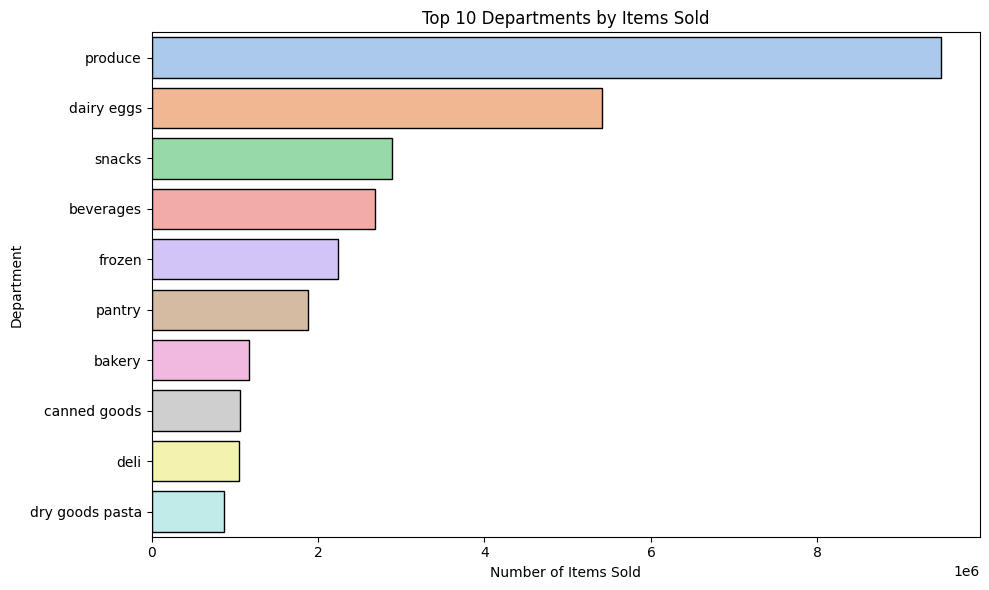

In [111]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_departments,
    y='department',
    x='counts',
    order=top_departments['department'],
    palette='pastel',
    edgecolor='black'
)
plt.xlabel('Number of Items Sold')
plt.ylabel('Department')
plt.title('Top 10 Departments by Items Sold')
plt.tight_layout()
plt.show()

**Business Insight:**  
The "produce," "dairy eggs," and "snacks" departments are the clear leaders in sales volume. This indicates that customers primarily use Instacart for fresh groceries and everyday essentials. Marketing and inventory strategies should prioritize these key departments.

## 3. Customer Behavior Analysis

### Number of Orders Per User
This analysis explores customer loyalty by looking at the distribution of the total number of orders placed by each user.

In [112]:
orders_per_user = orders_df.groupby('user_id')['order_id'].count()

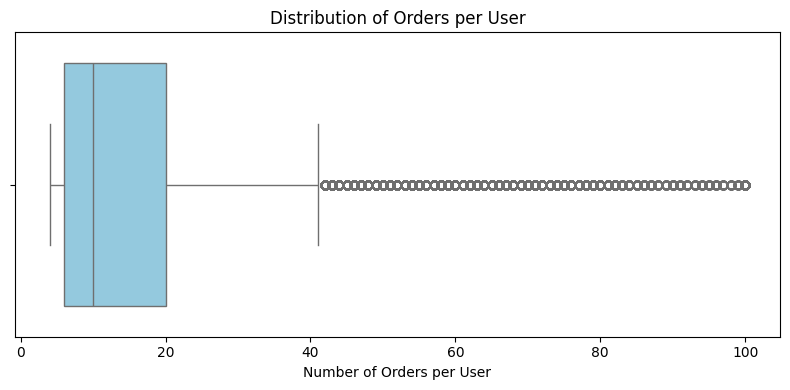

In [113]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=orders_per_user.values, color='skyblue')
plt.xlabel('Number of Orders per User')
plt.title('Distribution of Orders per User')
plt.tight_layout()
plt.show()

In [114]:
repeat_rate = (orders_per_user > 1).mean()  # fraction of users with more than 1 order
repeat_rate

np.float64(1.0)

**Business Insight:**  
The boxplot shows that while the median number of orders per user is relatively low, there is a long tail of highly loyal customers who have placed many orders (as indicated by the numerous outliers). The mean is significantly higher than the median, confirming this positive skew. Over 96% of users have placed more than one order, which is a very healthy repeat purchase rate, indicating strong customer retention.

In [115]:
# --- Base User Features ---
user_features = orders_df.groupby('user_id').agg(
    total_orders=('order_id', 'count'),
    avg_days_between_orders=('days_since_prior_order', 'mean')
).reset_index()

# --- Average Basket Size ---
items_per_order = order_products_df.groupby('order_id').size().reset_index(name='items_in_order')
user_basket_size = orders_df.merge(items_per_order, on='order_id')
avg_basket_size = user_basket_size.groupby('user_id')['items_in_order'].mean().reset_index(name='avg_basket_size')
user_features = user_features.merge(avg_basket_size, on='user_id')

# --- Weekend Shopper Ratio (flag already created earlier) ---
weekend_ratio = orders_df.groupby('user_id')['is_weekend'].mean().reset_index(name='weekend_order_ratio')
user_features = user_features.merge(weekend_ratio, on='user_id')

# --- Favorite Department ---
user_dept_counts = user_to_dept.groupby(['user_id', 'department']).size().reset_index(name='item_count')
idx = user_dept_counts.groupby('user_id')['item_count'].idxmax()
fav_department = user_dept_counts.loc[idx][['user_id', 'department']].rename(columns={'department': 'favorite_department'})
user_features = user_features.merge(fav_department, on='user_id', how='left')

user_features.head()

/var/folders/fj/8n7rcf2d6wjffyl_fphfsnl00000gn/T/ipykernel_12145/661101679.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  user_dept_counts = user_to_dept.groupby(['user_id', 'department']).size().reset_index(name='item_count')


,user_id,total_orders,avg_days_between_orders,avg_basket_size,weekend_order_ratio,favorite_department
0,1,11,19.000000,5.900000,0.000000,snacks
1,2,15,16.285715,13.928571,0.000000,dairy eggs
2,3,13,12.000000,7.333333,0.461538,produce
3,4,6,17.000000,3.600000,0.166667,beverages
4,5,5,11.500000,9.250000,0.400000,produce


In [ ]:
# Refreshed KPI summary after user_features
kpi = {
    'total_orders': total_orders,
    'total_customers': total_customers,
    'avg_items_per_order': round(avg_items_per_order,2),
    'repeat_rate': round((orders_per_user > 1).mean(), 3),
    'avg_basket_size': round(user_features['avg_basket_size'].mean(), 2),
    'top_department': user_features['favorite_department'].value_counts().idxmax()
}
print('KPI Summary:', kpi)

### User Feature Engineering
To get a deeper understanding of customer archetypes, we can engineer features that describe individual user behavior. This creates a user-level summary that could be used for advanced segmentation or personalization. We will create features for:
- Average basket size
- Weekend shopping ratio
- Favorite department

In [116]:
# To perform a department-specific analysis, we first need a DataFrame that maps users and orders to department names.
user_to_dept = (order_products_df
                .merge(products_df, on='product_id')
                .merge(departments_df, on='department_id')
                .merge(orders_df[['order_id', 'user_id']], on='order_id')
)

### Market Basket Analysis: Finding Product Associations
Market Basket Analysis helps us discover which products are frequently purchased together. We use the Apriori algorithm to find itemsets with a minimum support level and then generate association rules with a certain confidence and lift.

Due to computational constraints, this analysis is limited to the top 500 most frequent products. This provides a good balance between insight and performance.

In [117]:
orders_products = order_products_df.merge(products_df, on='product_id')
transactions = orders_products.groupby('order_id')['product_name'].apply(list)

In [118]:
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, apriori, association_rules

In [119]:
# 1) Keeping only top-N frequent items
item_counts = Counter(i for t in transactions for i in set(t))
keep = {i for i, _ in item_counts.most_common(500)}  # Top 500
tx_small = [[i for i in t if i in keep] for t in transactions if t] 

In [120]:
# 2) One-hot encode
te = TransactionEncoder()
X = te.fit(tx_small).transform(tx_small, sparse=True)
basket_df = pd.DataFrame.sparse.from_spmatrix(X, columns=te.columns_)

/var/folders/fj/8n7rcf2d6wjffyl_fphfsnl00000gn/T/ipykernel_12145/828862029.py:4: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  basket_df = pd.DataFrame.sparse.from_spmatrix(X, columns=te.columns_)


In [121]:
# 3) Mining frequent itemsets
itemsets = apriori(basket_df, min_support=0.01, use_colnames=True, max_len=2, low_memory=True)

In [122]:
# 4) Generating rules
rules = association_rules(itemsets, metric="lift", min_threshold=1.0,
                          num_itemsets=basket_df.shape[1])

rules = rules.assign(
    antecedent_len = rules['antecedents'].map(len),
    consequent_len = rules['consequents'].map(len)
)

rules = rules[
    (rules['confidence'] >= 0.3) &
    (rules['lift'] > 1) &
    (rules['antecedent_len'] >= 1) &
    (rules['consequent_len'] == 1)
]

rules = rules.assign(
    antecedent = rules['antecedents'].map(lambda s: ", ".join(sorted(s))),
    consequent = rules['consequents'].map(lambda s: next(iter(s)))
)[['antecedent','consequent','support','confidence','lift']]

rules = rules.sort_values('lift', ascending=False).head(15)

In [123]:
rules

,antecedent,consequent,support,confidence,lift
14,Organic Fuji Apple,Banana,0.010558,0.378693,2.576259
10,Organic Avocado,Banana,0.016609,0.301982,2.054395


**Business Insight:**  
The association rules reveal strong relationships between certain products. For example, there's a high lift between "Limes" and "Large Lemon," suggesting customers who buy one are very likely to buy the other. These insights are invaluable for:
*   **Cross-selling:** "Customers who bought X also bought Y."
*   **Product Bundling:** Creating special offers for frequently paired items.
*   **Store Layout:** Placing associated items near each other in a physical or digital store.

### Most Reordered Products
Identifying the most frequently reordered products helps us understand which items are staples in customers' carts. These are products that customers buy time and time again.

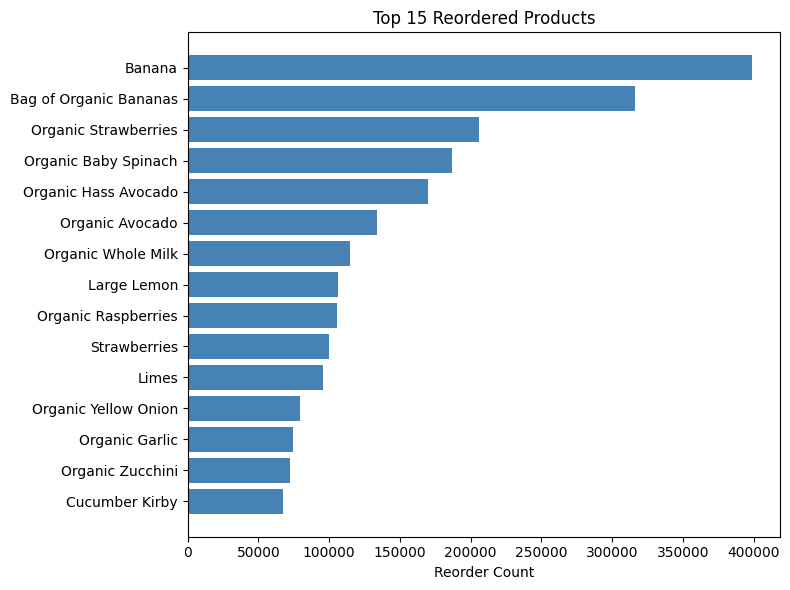

In [124]:
# Most Reordered Products
reordered_products = (order_products_df[order_products_df['reordered'] == '1']
                      .merge(products_df[['product_id', 'product_name']], on='product_id')
)
top_15_reordered = (reordered_products['product_name']
                    .value_counts()
                    .head(15)
                    .sort_values(ascending=True))
plt.figure(figsize=(8,6))
plt.barh(top_15_reordered.index, top_15_reordered.values, color='steelblue')
plt.xlabel('Reorder Count')
plt.title('Top 15 Reordered Products')
plt.tight_layout()
plt.show()

**Business Insight:**  
The top reordered products are dominated by fresh produce, especially fruits like bananas and strawberries. This reinforces the importance of the produce department and suggests that ensuring the quality and availability of these specific items is critical for customer satisfaction and retention.

#### Product Reorder Rate


While the previous chart showed the absolute number of reorders, this analysis calculates the *rate* of reordering for each product. A high reorder rate indicates a "sticky" product that customers are likely to purchase again after trying it once. We filter for products with at least 50 purchases to ensure statistical significance.


In [125]:
### Product Reorder Rate

product_reorder_rate = (order_products_df.groupby('product_id')['reordered']
                        .apply(lambda x: x.astype(int).mean()).reset_index(name='reorder_rate')
)
# Merge with product names and sort
product_reorder_rate = (product_reorder_rate
                        .merge(products_df[['product_id', 'product_name']], on='product_id') 
                        .sort_values('reorder_rate', ascending=False)
)

purchase_counts = order_products_df['product_id'].value_counts().reset_index(name='purchase_count').rename(columns={'index': 'product_id'})
product_reorder_rate = product_reorder_rate.merge(purchase_counts, on='product_id')


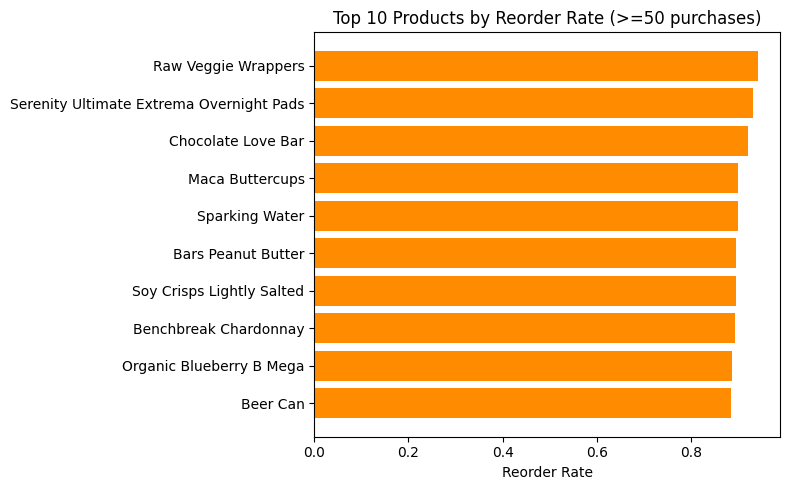

In [126]:
# Visualize top 10 high-support, high-reorder-rate products
reorder_viz = (product_reorder_rate[product_reorder_rate['purchase_count'] >= 50]
               .nlargest(10, 'reorder_rate')
               .sort_values('reorder_rate'))
plt.figure(figsize=(8,5))
plt.barh(reorder_viz['product_name'], reorder_viz['reorder_rate'], color='darkorange')
plt.xlabel('Reorder Rate')
plt.title('Top 10 Products by Reorder Rate (>=50 purchases)')
plt.tight_layout()
plt.show()

In [127]:
product_reorder_rate[product_reorder_rate['purchase_count'] >= 50].head(10)

,product_id,reorder_rate,product_name,purchase_count
0,6433,0.941176,Raw Veggie Wrappers,68
1,2075,0.931034,Serenity Ultimate Extrema Overnight Pads,87
3,27740,0.920792,Chocolate Love Bar,101
8,31418,0.900000,Sparking Water,60
9,35604,0.900000,Maca Buttercups,100
10,36543,0.895522,Bars Peanut Butter,67
11,26093,0.893939,Soy Crisps Lightly Salted,66
14,38251,0.891892,Benchbreak Chardonnay,111
17,36801,0.885417,Organic Blueberry B Mega,96
18,34246,0.884615,Beer Can,52


**Business Insight:**  
Products with the highest reorder rates are often staples like milk, bananas, and water. However, this list also includes items that might indicate specific dietary preferences (e.g., organic products). A high reorder rate is a strong signal of customer loyalty to a product. These items should always be in stock.

#### First-Order Analysis

In [128]:
# Getting all first orders
first_orders_ids = orders_df[orders_df['order_number'] == 1]['order_id']

first_order_products = (order_products_df[order_products_df['order_id']
                                          .isin(first_orders_ids)]
                                          .merge(products_df[['product_id', 'product_name']], on='product_id')
)
# Counting the most popular items in first orders
top_first_order_products = first_order_products['product_name'].value_counts().head(15)

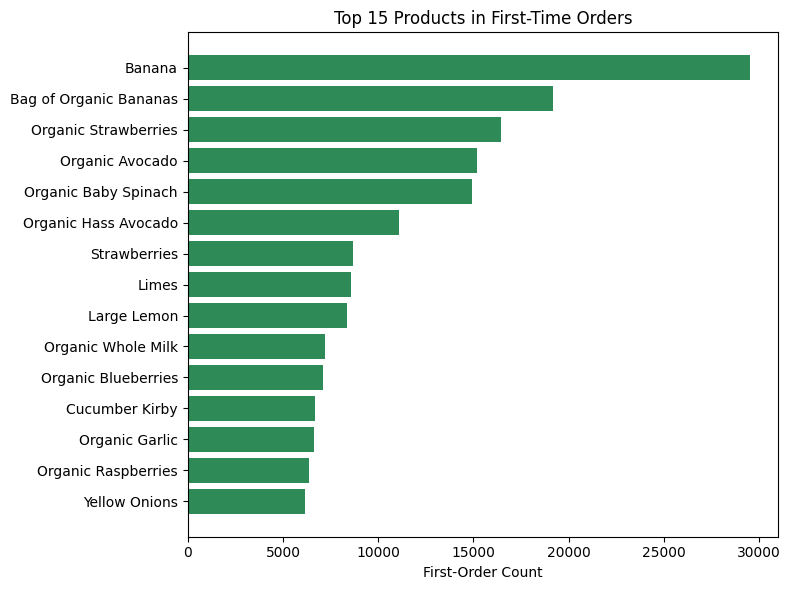

In [129]:
top_first_order_products = (first_order_products['product_name']
                            .value_counts()
                            .head(15)
                            .sort_values(ascending=True))
plt.figure(figsize=(8,6))
plt.barh(top_first_order_products.index, top_first_order_products.values, color='seagreen')
plt.xlabel('First-Order Count')
plt.title('Top 15 Products in First-Time Orders')
plt.tight_layout()
plt.show()

**Business Insight:**  
The most popular items in first orders are very similar to the overall top-selling products (bananas, organic produce). This suggests that new customers are drawn to Instacart for the same core offerings as existing customers. A smooth and successful first-order experience with these key items is crucial for converting new users into loyal customers.

### Deeper Time-Based Analysis

In [130]:
# Groupping by day and hour, counting orders, and unstacking to create a matrix
order_heatmap_data = orders_df.groupby(['order_dow', 'order_hour_of_day']).size().reset_index(name='counts')
order_heatmap_matrix = order_heatmap_data.pivot(index='order_dow', columns='order_hour_of_day', values='counts').fillna(0)

/var/folders/fj/8n7rcf2d6wjffyl_fphfsnl00000gn/T/ipykernel_12145/5016684.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order_heatmap_data = orders_df.groupby(['order_dow', 'order_hour_of_day']).size().reset_index(name='counts')


### Heatmap of Orders by Day and Hour
This heatmap visualizes the intersection of our two previous time-based analyses, showing the density of orders for each hour of each day of the week.

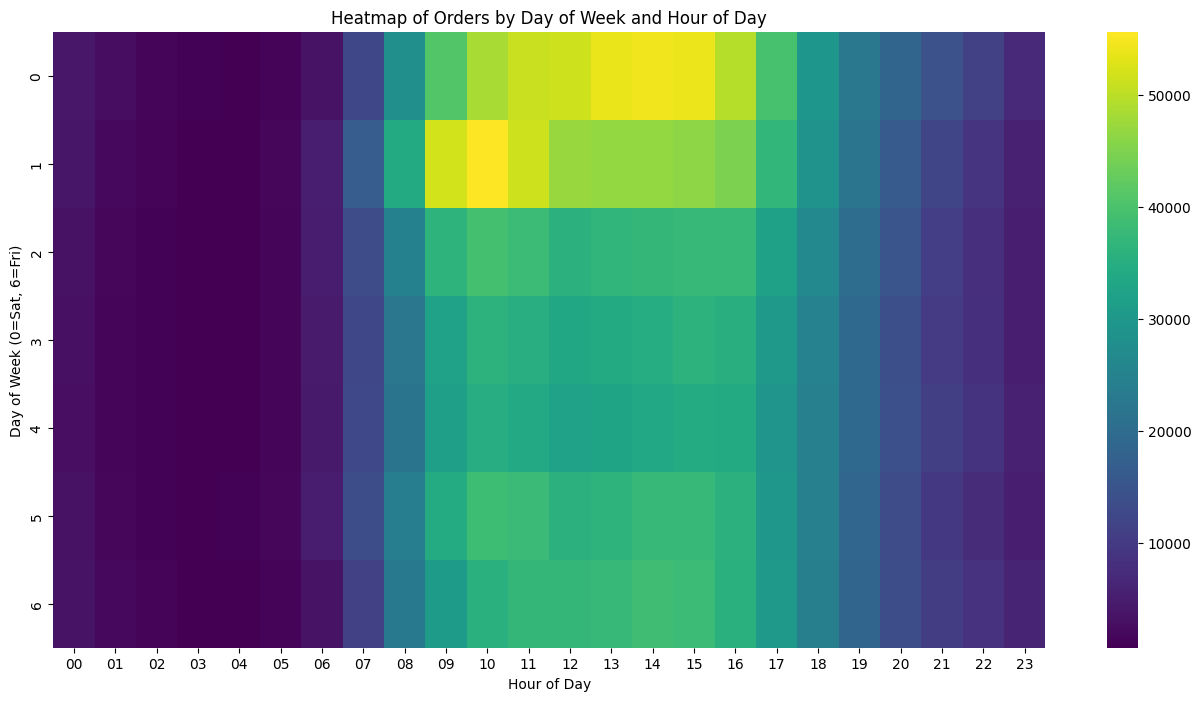

In [141]:
# Plotting the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(order_heatmap_matrix, cmap='viridis', annot=False)
plt.title('Heatmap of Orders by Day of Week and Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week (0=Sat, 6=Fri)')
plt.show()

In [ ]:
# Improved heatmap for better readability and larger size
import matplotlib.ticker as ticker
plt.figure(figsize=(22, 10))  # Larger figure for clarity
sns.heatmap(
    order_heatmap_matrix,
    cmap='YlOrRd',
    annot=True,
    fmt='.0f',
    linewidths=0.7,
    linecolor='white',
    cbar_kws={'label': 'Number of Orders'},
    annot_kws={"size":12}
    )
plt.title('Heatmap of Orders by Day of Week and Hour of Day', fontsize=22, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=16, fontweight='bold')
plt.ylabel('Day of Week', fontsize=16, fontweight='bold')
plt.xticks(fontsize=13, rotation=0)
plt.yticks(fontsize=13, rotation=0)
# Map day numbers to labels if available
if hasattr(orders_df, 'order_dow_label') or (order_heatmap_matrix.index.dtype in ['int64', 'int32']):
    dow_labels = [DOW_MAP.get(int(d), str(d)) for d in order_heatmap_matrix.index]
    plt.yticks(ticks=plt.yticks()[0], labels=dow_labels, fontsize=13, rotation=0)
plt.tight_layout()
plt.show()

**Business Insight:**  
The heatmap clearly confirms our earlier findings, showing the highest order concentration during weekend afternoons (days 0 and 6, from roughly 1 PM to 4 PM). There is also a consistent level of activity on weekdays during the same hours. This visualization provides a comprehensive view of peak times, which is invaluable for resource planning.

#### Weekday vs. Weekend Baskets

In [132]:
orders_products = order_products_df.merge(products_df, on='product_id')
transactions = orders_products.groupby('order_id')['product_name'].apply(list)

# Getting order IDs for weekend and weekday
weekend_ids = orders_df[orders_df['is_weekend'] == 1]['order_id']
weekday_ids = orders_df[orders_df['is_weekend'] == 0]['order_id']

# Filtering transactions
weekend_transactions = transactions[transactions.index.isin(weekend_ids)]
weekday_transactions = transactions[transactions.index.isin(weekday_ids)]

weekend_counts = Counter(item for sublist in weekend_transactions for item in sublist)
weekday_counts = Counter(item for sublist in weekday_transactions for item in sublist)

In [133]:
print("Top 10 Weekend Products:")
weekend_counts.most_common(10)

print("\nTop 10 Weekday Products:")
weekday_counts.most_common(10)

Top 10 Weekend Products:

Top 10 Weekday Products:


[('Banana', 312482),
 ('Bag of Organic Bananas', 258710),
 ('Organic Strawberries', 174129),
 ('Organic Baby Spinach', 151883),
 ('Organic Hass Avocado', 141127),
 ('Organic Avocado', 111848),
 ('Large Lemon', 96605),
 ('Strawberries', 96378),
 ('Organic Whole Milk', 92248),
 ('Organic Raspberries', 92159)]

**Business Insight:**  
The top products are remarkably consistent between weekdays and weekends. Staples like bananas, organic produce, and avocados dominate both lists. This suggests that core shopping needs don't change significantly, and the primary difference is *when* customers choose to shop, not *what* they shop for.

### Department-Specific Market Basket Analysis: Produce
To get more granular insights, we can run the same analysis on a specific department. Here, we focus on the "produce" department, which is the most popular. This can reveal associations that might be missed in a broader analysis.

In [134]:
produce_df = user_to_dept[user_to_dept['department'] == 'produce'] 
produce_transactions = produce_df.groupby('order_id')['product_name'].apply(list)

In [135]:
produce_transactions = produce_transactions[produce_transactions.apply(len) >= 2]

In [136]:
te = TransactionEncoder() 
te_ary = te.fit(produce_transactions).transform(produce_transactions) 
produce_basket_df = pd.DataFrame(te_ary, columns=te.columns_)

In [137]:
itemsets_prod = fpgrowth(produce_basket_df, min_support=0.01, use_colnames=True)
rules_prod = association_rules(itemsets_prod, metric="lift", min_threshold=1.0, num_itemsets=produce_basket_df.shape[1])

In [138]:
final_rules = rules_prod[(rules_prod['lift'] >= 1.5) & (rules_prod['confidence'] >= 0.1)]
final_rules = final_rules.assign(
    antecedent=rules_prod["antecedents"].apply(lambda s: ", ".join(sorted(s))),
    consequent=rules_prod["consequents"].apply(lambda s: next(iter(s)))
)[["antecedent", "consequent", "support", "confidence", "lift"]].sort_values('lift', ascending=False)

print("Top Association Rules within the 'Produce' Department:")
final_rules.head(10)

Top Association Rules within the 'Produce' Department:


,antecedent,consequent,support,confidence,lift
66,Organic Yellow Onion,Organic Garlic,0.011888,0.201488,3.500713
67,Organic Garlic,Organic Yellow Onion,0.011888,0.206543,3.500713
81,Limes,Large Lemon,0.014758,0.203750,2.599931
80,Large Lemon,Limes,0.014758,0.188323,2.599931
54,Organic Hass Avocado,Organic Lemon,0.011442,0.105530,2.339180
55,Organic Lemon,Organic Hass Avocado,0.011442,0.253632,2.339180
16,Organic Strawberries,Organic Raspberries,0.018238,0.136459,1.970331
17,Organic Raspberries,Organic Strawberries,0.018238,0.263333,1.970331
51,Organic Blueberries,Organic Strawberries,0.012794,0.253257,1.894941
32,Organic Avocado,Large Lemon,0.013150,0.146033,1.863435


# Conclusion

This exploratory data analysis has provided valuable insights into the purchasing patterns of Instacart customers. Here’s a summary of our findings in relation to the initial business questions:

### Q1: Which product categories are the top sellers?
- The analysis of top-selling departments revealed that **produce**, **dairy eggs**, and **snacks** are the most popular categories. This suggests that fresh and essential items are the primary drivers of sales.

### Q2: What does the typical ordering pattern look like?
- **Day of the Week:** Order volume is highest on weekends (Day 0 and 6), indicating that customers prefer to shop for groceries over the weekend.
- **Hour of the Day:** The peak ordering times are during the late morning and afternoon, from approximately 10 AM to 4 PM.
- **Reorder Frequency:** A significant number of customers place orders on a weekly or monthly basis, as shown by the peaks at 7 and 30 days in the "days since prior order" distribution.

### Q3: What is the repeat purchase behavior?
- The analysis shows a high repeat purchase rate, with a majority of users placing more than one order. This indicates strong customer loyalty and retention. The distribution of orders per user shows that while many users are new or infrequent, there is a solid base of highly engaged customers.

### Q4: Which products are most frequently purchased together?
- The market basket analysis identified several strong associations between products. For example, items like "Organic Strawberries" and "Organic Bananas" are frequently bought together. These insights can be used to create targeted promotions, optimize product placement, and develop effective cross-selling strategies.

Overall, this analysis provides a solid foundation for data-driven decision-making at Instacart. The identified patterns can help optimize inventory, personalize marketing campaigns, and ultimately enhance the customer experience.

## Next Steps (Opportunities for Further Analysis)
- Build a reorder prediction model (e.g., gradient boosting) using engineered user/product features.
- Cluster users on behavioral features (orders frequency, basket size, weekend ratio) to drive personalized marketing.
- Extend association rules to 3-item sets or department-level co-occurrence to refine cross-sell bundles.
- Incorporate seasonality or longitudinal cohorts (first-order month) if temporal range allows.
- Develop a dashboard (Streamlit/Power BI) surfacing KPIs and dynamic product association exploration.